In [1]:
# Install dependencies
#!pip install albumentations==0.4.6
!pip install albumentations
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 220842, done.
remote: Counting objects: 100% (1122/1122), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 220842 (delta 1031), reused 1101 (delta 1023), pack-reused 219720
Receiving objects: 100% (220842/220842), 444.55 MiB | 9.79 MiB/s, done.
Resolving deltas: 100% (199849/199849), done.
/home/jupyter/Object Detection/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/home/jupyter/Object Detection


In [1]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


### Importar json con etiquetas

In [2]:
# importing the module
import json
 
# Opening JSON file
with open('/home/jupyter/Falabella/dict_bbox_p123_revisada_cf.json') as json_file:
    dict_data = json.load(json_file)

In [3]:
# revisar
len(dict_data)

13135

### Definir clase

In [4]:
from skimage import io
class PhotosLabelsDataset_od(torch.utils.data.Dataset):
    """Photos labels dataset."""

    def __init__(self, dictionary, root_dir, transforms=None):
        """
        Args:
            xlsx_file (string): Path to the xlsx file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Boolean that indicates 
            a transformation or not.
        """
        self.dict_values = list(dictionary.values())
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dict_values)

    def __getitem__(self, idx):

        dict_values = self.dict_values
        
        # obtener nombre fotografía
        img_name = dict_values[idx]['image_id']
        image_path = os.path.join(self.root_dir, img_name) 
        # leer imágen
        image =io.imread(image_path)
        
        # obtener 'boxes'
        boxes = dict_values[idx]['boxes']
        # calcular numero de 'boxes'
        num_box = len(boxes)
        # obtener formato adecuado para 'boxes'
        if num_box>0:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
        else:
          #negative example, ref: https://github.com/pytorch/vision/issues/2144
          boxes = torch.zeros((0, 4), dtype=torch.float32)

        # obtener área de las 'boxes'
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suponer que las instancias no forman aglomeraciones
        iscrowd = torch.zeros((num_box,), dtype=torch.int64)

        # obtener etiquetas para clase 1
        labels = torch.ones((num_box,), dtype=torch.int64)
        
        # rellenar diccionario de etiquetas 'target'
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        # si hay transformaciones, entonces se aplican al conjunto de datos
        # correspondientes
        if self.transforms:
          sample = self.transforms(image = image,
                                bboxes = target["boxes"],
                                labels = labels)
          image = sample['image']
          if len(sample['bboxes']) == 0 :
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

          else:
            target['boxes'] = torch.Tensor(sample['bboxes'])
          
          image = image.float().div(255)
        
        return image, target

In [5]:
# Revisar dataset
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
dataset = PhotosLabelsDataset_od(dictionary = dict_data, root_dir = path_fotografias, transforms=None)
print('Length of dataset:', len(dataset), '\n')

# Obtener tamaño de imágen cualquiera y el label respectivo
img, target = dataset[325]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 13135 

Image shape: (256, 192, 3)
Label example: {'boxes': tensor([[ 38.,  33., 186., 150.],
        [ 17., 138., 182., 256.]]), 'labels': tensor([1, 1]), 'area': tensor([17316., 19470.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([325])}


In [5]:
# REFERENCIAR
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min x-max y-max
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  
  plt.show()

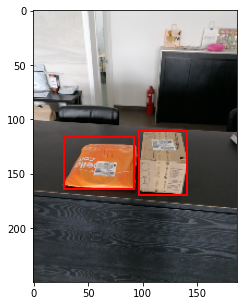

{'boxes': tensor([[ 28., 116.,  92., 164.],
        [ 97., 111., 141., 170.]]), 'labels': tensor([1, 1]), 'area': tensor([3072., 2596.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}


In [7]:
# mostrar imágen con bbox e imprimir target
img, target = dataset[9]
plot_img_bbox(img, target)
print(target)

### Separar data en train y val

In [19]:
# separar diccionario en train, test y validation, antes de generar el dataset
from sklearn.model_selection import train_test_split

rs = 0
s = pd.Series(dict_data)
train_data , dict_test  = [i.to_dict() for i in train_test_split(s, train_size=0.8, random_state=rs)]
test_data_0 = pd.Series(dict_test)
test_data , val_data  = [i.to_dict() for i in train_test_split(test_data_0, train_size=0.5, random_state=rs)]

print('train: ', len(train_data))
print('test: ', len(test_data))
print('validation: ', len(val_data))

train:  10508
test:  1313
validation:  1314


In [20]:
# función para contabilizar elementos de cada clase
def labels_quantity(dic):
  positive = 0
  negative = 0
  for i in dic:
    if dic[i]['labels']:
      positive+=1
    else:
      negative+=1
  return positive, negative

In [22]:
p_train, n_train = labels_quantity(train_data)
p_test, n_test = labels_quantity(test_data)
p_val, n_val = labels_quantity(val_data)

print('p_train: ', p_train, ' ', 'n_train', n_train)
print('p_test: ', p_test, ' ', 'n_test', n_test)
print('p_test: ', p_val, ' ', 'n_test', n_val)

p_train:  7946   n_train 2562
p_test:  963   n_test 350
p_test:  976   n_test 338


### Transformaciones

In [32]:
# Inicializar transformaciones

# normalización para conjunto de validación 
val_transform = A.Compose(
        [
         # ToTensorV2 converts image to pytorch tensor without div by 255
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         ) 

# transformaciones para conjunto de train
train_transform_0 = A.Compose(
        [
            A.Resize (480, 480),
         A.HorizontalFlip(0.5),
         A.VerticalFlip(0.5),
         A.RandomBrightnessContrast(p=0.5),
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

train_transform_1 = A.Compose(
        [
            A.Resize (480, 480),
            A.RandomCrop(width=432, height=432, p=0.5), # recorte de 90%
         A.HorizontalFlip(0.5),
         A.VerticalFlip(0.5),
         A.RandomBrightnessContrast(p=0.5),
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

### Dataset con primera configuración de transformación

In [34]:
train_transform = train_transform_0
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
train_set = PhotosLabelsDataset_od(dictionary = train_data, root_dir = path_fotografias, transforms=train_transform)
test_set = PhotosLabelsDataset_od(dictionary = test_data, root_dir = path_fotografias, transforms=val_transform)
val_set = PhotosLabelsDataset_od(dictionary = val_data, root_dir = path_fotografias, transforms=val_transform)

### Dataset con segunda configuración de transformación

In [38]:
# dataset con primera configuración de transformación
train_transform = train_transform_1
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
train_set = PhotosLabelsDataset_od(dictionary = train_data, root_dir = path_fotografias, transforms=train_transform)
test_set = PhotosLabelsDataset_od(dictionary = test_data, root_dir = path_fotografias, transforms=val_transform)
val_set = PhotosLabelsDataset_od(dictionary = val_data, root_dir = path_fotografias, transforms=val_transform)

### Generar batches de train y val

In [35]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10,
                        shuffle=True, num_workers=4, 
                         collate_fn=utils.collate_fn,)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10,
                        shuffle=False, num_workers=4, 
                        collate_fn=utils.collate_fn,)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=10,
                        shuffle=False, num_workers=4, 
                        collate_fn=utils.collate_fn,)

### Función para cargar modelo

In [2]:
# REFERENCIAR!
# función de ayuda para cargar modelo
def get_object_detection_model(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

### Funciones "eval_forward" y "evaluate_loss" para calcular perdidas
Obtenido de https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch

In [37]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [38]:
#I determine validation loss by looking at the losses dictionary, 
#sum all of these losses, and at the end average them by the length of the dataloader
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    with torch.no_grad():
      for images, targets in data_loader:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          losses_dict, detections = eval_forward(model, images, targets)
         
          losses = sum(loss for loss in losses_dict.values())

          val_loss += losses
          
    validation_loss = val_loss/ len(data_loader)    
    return validation_loss

## Entrenamiento

### Función de entrenamiento con early stop

In [40]:
def train_early_stop(name, num_epochs, epochs_limit, model, optimizer, \
                     trainloader, testloader, device, model_path, \
                     print_freq = 100):
    """
    Args:
        name (str): nombre del modelo
        num_epochs (int): numero de épocas de entrenamiento
        epochs_limit (int): límite de épocas para detener early stopping
        model: modelo
        optimizer: optimizador
        trinloader: batches de entrenamiento
        tesloader: batches de validación
        device (str): dispositivo en el cual entrenar
        model_path (str): ubicación en donde se guardarán parámetros del modelo
        print_freq: numero de batches para imprimir info.
          
    Returns:
       model_dict (dict): toda la info. del modelo entrenado    
    """
    # mover modelo al dispositivo 
    model.to(device)
    # inicializar pérdida de validación inicial
    validation_loss_ini = 1000
    # inicializar listas para almacenar pérdidas (train y val)
    train_losses = []
    val_losses = []
    # inicializar variable epochs
    epochs = 0
    # inicializar diccionario evaluation_dic
    evaluation_dic = {}
    for epoch in range(num_epochs):
        # entrenamiento por epoca
        train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq)
        # actualizar learning rate
        lr_scheduler.step()
    
        # función para calcular pérdidas de entrenamiento y validación
        training_loss = evaluate_loss(model, trainloader, device=device)
        # guardar pérdida de entrenamiento en lista
        train_losses.append(training_loss)
        print('training_loss:', training_loss)
    
        validation_loss  = evaluate_loss(model, testloader, device=device)
        # guardar perdida de validación en lista
        val_losses.append(validation_loss)
        print('validation_loss:', validation_loss) 
    
        # Early stopping
        
        # si pérdida de validación es menor a la mínima pérdida de validación
        # obtenida hasta el momento, se guarda el modelo
        if validation_loss < validation_loss_ini:
          # se guarda el modelo
          torch.save({
              'train_losses': train_losses,
              'val_losses': val_losses,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'validation loss': validation_loss,
                }, model_path)
          # se actualiza validation_loss
          validation_loss_ini = validation_loss
          # se actualiza variable epochs
          epochs = 0
        
        # si pérdida de validación es mayor o igual a la mínima pérdida de validación
        # obtenida hasta el momento y además, las epocas son menor al límite de epocas
        # propuesto, entonces se actualiza variable epochs
        elif validation_loss >= validation_loss_ini and epochs < epochs_limit:
          # se actualiza variable epochs  
          epochs += 1
    
        else:
          # se termina entrenamiento
          break
        
        # evaluar métricas en el test 
        evaluation = evaluate(model, testloader, device=device)
        key = 'epoch_' + str(epoch)
        evaluation_dic[key] = evaluation
        
    # actualizar diccionario con todas las pérdidas (train y val) 
    model_dict = torch.load(model_path)
    model_dict['name'] = name
    model_dict['train_losses'] = train_losses
    model_dict['val_losses'] = val_losses
    model_dict['evaluation_dic'] = evaluation_dic
    
    torch.save(model_dict, model_path)
    
    print('Finished Training')
    
    return model_dict

### Función de entrenamiento con todo el dataset

In [45]:
def train_all_set(name, num_epochs, model, optimizer, \
                     dataloader, device, model_path, \
                  print_freq = 100):
    """
    Args:
        name (str): nombre del modelo
        num_epochs (int): numero de épocas de entrenamiento
        model: modelo
        optimizer: optimizador
        trinloader: batches de entrenamiento
        tesloader: batches de validación
        device (str): dispositivo en el cual entrenar
        model_path (str): ubicación en donde se guardarán parámetros del modelo
        print_freq: numero de batches para imprimir info.
          
    Returns:
       model_dict (dict): toda la info. del modelo entrenado    
    """
    # mover modelo al dispositivo 
    model.to(device)
    for epoch in range(num_epochs):
        # entrenamiento por epoca
        train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        # actualizar learning rate
        lr_scheduler.step()
    
    # se guarda el modelo
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)
    
    # cargar modelo
    model_dict = torch.load(model_path)
    model_dict['name'] = name
    
    torch.save(model_dict, model_path)
    
    print('Finished Training')
    
    return model_dict

### Entrenar modelo con early stopping

In [41]:
# entrenar en gpu si es posible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# definir numero de clases
num_classes = 2 # one class (class 0) is dedicated to the "background"

# obtener modelo mediante función de ayuda
model = get_object_detection_model(num_classes)

# optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# se define un learning rate scheduler que decrementa el learning rate por 
# 10x cada 3 epocas -> ej: 0.005 si epoca < 3, 0.0005 si 3 <= epoca < 6, etc
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [42]:
# Entrenar modelo
num_epochs = 100
epochs_limit = 10
model_path = '/home/jupyter/Falabella/model_cf_12y3_3.pth'
name = 'model_cf_12y3_3'

model_dict = train_early_stop(name, num_epochs, epochs_limit, model, \
                 optimizer, trainloader, validationloader, device, model_path, \
                 print_freq = 100)

Epoch: [0]  [   0/1051]  eta: 1:37:55  lr: 0.000010  loss: 1.2032 (1.2032)  loss_classifier: 1.0339 (1.0339)  loss_box_reg: 0.1536 (0.1536)  loss_objectness: 0.0099 (0.0099)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 5.5902  data: 0.9355  max mem: 8206
Epoch: [0]  [ 100/1051]  eta: 0:32:13  lr: 0.000509  loss: 0.1860 (0.3624)  loss_classifier: 0.0701 (0.2176)  loss_box_reg: 0.0965 (0.1171)  loss_objectness: 0.0062 (0.0192)  loss_rpn_box_reg: 0.0035 (0.0086)  time: 2.1489  data: 0.0196  max mem: 8472
Epoch: [0]  [ 200/1051]  eta: 0:29:21  lr: 0.001009  loss: 0.1488 (0.2671)  loss_classifier: 0.0469 (0.1380)  loss_box_reg: 0.0856 (0.1090)  loss_objectness: 0.0060 (0.0137)  loss_rpn_box_reg: 0.0033 (0.0065)  time: 2.1189  data: 0.0202  max mem: 8472
Epoch: [0]  [ 800/1051]  eta: 0:08:47  lr: 0.004006  loss: 0.0753 (0.1337)  loss_classifier: 0.0290 (0.0602)  loss_box_reg: 0.0418 (0.0611)  loss_objectness: 0.0039 (0.0083)  loss_rpn_box_reg: 0.0030 (0.0042)  time: 2.1187  data: 0.0234  max me

In [43]:
# cargar modelo ya entrenado
model_path = '/home/jupyter/Falabella/model_cf_12y3_3.pth'
num_classes = 2
model = get_object_detection_model(num_classes)
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [46]:
# Evaluar en test
device = 'cuda'
model.to(device)
evaluate(model, testloader, device=device)

creating index...
index created!
Test:  [  0/132]  eta: 0:04:14  model_time: 1.4833 (1.4833)  evaluator_time: 0.0090 (0.0090)  time: 1.9251  data: 0.4276  max mem: 10314
Test:  [100/132]  eta: 0:00:55  model_time: 1.8672 (1.7096)  evaluator_time: 0.0051 (0.0050)  time: 1.7335  data: 0.0199  max mem: 10314
Test:  [131/132]  eta: 0:00:01  model_time: 1.5196 (1.7075)  evaluator_time: 0.0047 (0.0049)  time: 1.6504  data: 0.0181  max mem: 10314
Test: Total time: 0:03:49 (1.7378 s / it)
Averaged stats: model_time: 1.5196 (1.7075)  evaluator_time: 0.0047 (0.0049)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=

### Graficar curva de pérdidas

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

train_losses = model_dict['train_losses']
val_losses = model_dict['val_losses']

# training and validation loss
mpl.style.use('seaborn')
plt.plot(list(range(len(train_losses))), train_losses, 'teal', label='Training loss')
plt.plot(list(range(len(val_losses))), val_losses, 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Entrenamiento con todo el dataset

In [3]:
# cargar modelo ya entrenado
model_path = '/home/jupyter/Falabella/model_cf_12y3_1.pth'
num_classes = 2
model = get_object_detection_model(num_classes)
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [4]:
# obtener epoca óptima
optimal_epoch = model_dict['epoch']
print(optimal_epoch)

KeyError: 'epoch'

In [ ]:
# generar dataset
# FIJARSE QUE TRANSFORMACIÓN SEA LA MISMA CON LA CUAL SE REALIZÓ 
# EL EARLY STOPPING
dataset = PhotosLabelsDataset_od(dictionary = dict_data, root_dir = path_fotografias, transforms=train_transform)

In [ ]:
# comprobar largo dataset
len(dataset)

In [ ]:
# generar baches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,
                        shuffle=True, num_workers=4, 
                        collate_fn=utils.collate_fn,)

#### Re-inicializar el modelo con mismos parámetros que para early stopping

In [ ]:
# entrenar en gpu si es posible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# definir numero de clases
num_classes = 2 # one class (class 0) is dedicated to the "background"

# obtener modelo mediante función de ayuda
model = get_object_detection_model(num_classes)

# optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# se define un learning rate scheduler que decrementa el learning rate por 
# 10x cada 3 epocas -> ej: 0.005 si epoca < 3, 0.0005 si 3 <= epoca < 6, etc
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [ ]:
# Entrenar modelo

num_epochs = 100
epochs_limit = 5
model_path = '/home/jupyter/Falabella/model_cf_12y3_2_full.pth'
name = 'model_cf_12y3_2_full'

model_dict = train_all_set(name, num_epochs, model, optimizer, \
                     dataloader, device, model_path, \
                  print_freq = 100):

In [ ]:
# training for 5 epochs
num_epochs = optimal_epoch
#PATH = './model_sf.pth'
PATH = '/home/jupyter/Falabella/model_cf_12y3_1.pth'

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
# se guarda el modelo
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Evaluación modelo

### Revisión del modelo en algunas imágenes de test

#### Función para dibujar true_bbox y predicted_bbox

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target, axs, i, j, device, prediction = None):
  axs[i,j].imshow(img.to(device))
  
  if prediction:
    boxes = target['boxes'].to(device)
    indice = 0
    for score in target['scores']:
      if score >= 0.5:
        box = boxes[indice]
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
        )
        # Draw the bounding box on top of the image
        axs[i,j].add_patch(rect) 
      indice+=1      
  
  else:
    for box in (target['boxes'].to(device)):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
      )
      # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)

#### Imágenes

In [ ]:
# Visualización de algunas imagenes 
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
for i in range(h):
  for j in range(w):
    img, label = test_set[idx]
    idx+=1
    plot_img_bbox(img.permute(1,2,0), label, axs, i, j, 'cpu')

In [ ]:
# Visualización de predicciones
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for i in range(h):
    for j in range(w):
      img, _ = test_set[idx]
      prediction = model([img.to(device)])
      idx+=1
      plot_img_bbox(img.permute(1,2,0), prediction[0], axs, i, j, 'cpu', True)

### Prueba con 1000_test

In [4]:
# función para calcular accuracy 1:1, obtener true_labels, predicciones
# y scores
import os
from skimage import io, transform

def od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda'):
  acc = 0
  df = pd.read_excel(path_xlsx)
  model.to(device)
  model.eval()              # turn the model to evaluate mode
  count = 0
  #y_test = []
  y_true = []
  y_pred = []
  y_score = []
  aciertos = 0
  with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transform.resize(image, (480, 480))
      t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = model([t_img])
      if prediction[0]['labels'].shape[0] > 0 and max(prediction[0]['scores']).item() >= 0.5:
      #if prediction[0]['labels'].shape[0] > 0: 
        pred_class = 1
      else:
        pred_class = 0
      y_pred.append(pred_class)
      indice = int(img_name.split('.')[0])
      true_class = df.loc[indice]['Producto']
      #y_test.append(true_class)
      y_true.append(true_class)
      if prediction[0]['labels'].shape[0] > 0:
        y_score.append(max(prediction[0]['scores']).item())
      else:
        y_score.append(0)
      if pred_class == true_class:
        aciertos += 1
      else:
        pass
      count+=1
    acc = aciertos/count

    return acc, y_true, y_pred, y_score

In [5]:
path_images = '/home/jupyter/Falabella/test_1000_imagenes/imagenes'
path_xlsx= '/home/jupyter/Falabella/test_1000_imagenes/etiquetado ML_revisada.xlsx'
od_acc, y_true_list, y_pred_list, y_score_list= od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda')

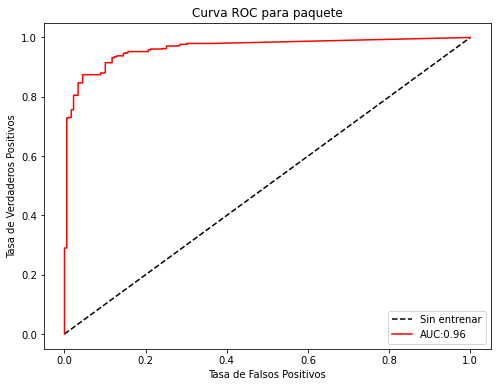

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
# Curva ROC para etiqueta
#############################
#plt.figure(figsize=(200,200))
#############################
fpr, tpr, thres = roc_curve(y_true_list , y_score_list)
plt.figure(figsize=(8,6)) 
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--', label='Sin entrenar')
auc = roc_auc_score(y_true_list, y_score_list)
label = 'AUC:' + str(round(auc,2))
plt.plot(fpr, tpr, label = label, color = 'red')
# Etiquetas gráfico
plt.title('Curva ROC para paquete')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
#-------------------------------------------------------------------------------
# Obtener mejor threshold
#P = tpr - fpr
#ix = argmax(P)
# Enontrar mejor umbral
#best_thres = thres[ix]
#print('Mejor umbral=%f, fpr = %f, tpr = %f' 
#      % (thres[ix], fpr[ix], tpr[ix]))
## plot the roc curve for the model
#plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
#plt.annotate(str(round(best_thres,4)) + ' (' + str(round(fpr[ix],4)) + ' , ' + str(round(tpr[ix],4)) + ')',
#            xy=(fpr[ix], tpr[ix]), xycoords='data',
#            xytext=(fpr[ix], tpr[ix]+0.07), textcoords='data',
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            )
######################################################################
#for ix in range(len(P)):
#  if ix%2==0:
#    plt.scatter(fpr[ix], tpr[ix], marker='*', color='black')
#    plt.annotate(str(round(thres[ix],3)),
#            xy=(fpr[ix], tpr[ix]), xycoords='data',
#            xytext=(fpr[ix], tpr[ix]), textcoords='data', horizontalalignment = 'center',
#            verticalalignment = 'bottom')
#    plt.annotate('(' + str(round(fpr[ix],3)) + ' , ' + str(round(tpr[ix],3)) + ')',
#            xy=(fpr[ix], tpr[ix]), xycoords='data',
#            xytext=(fpr[ix], tpr[ix]), textcoords='data', horizontalalignment = 'center',
#            verticalalignment = 'top')
#plt.plot()
####################################################################### 
#-------------------------------------------------------------------------------
plt.savefig('/home/jupyter/Object Detection/graficos/roc2')
#plt.show()

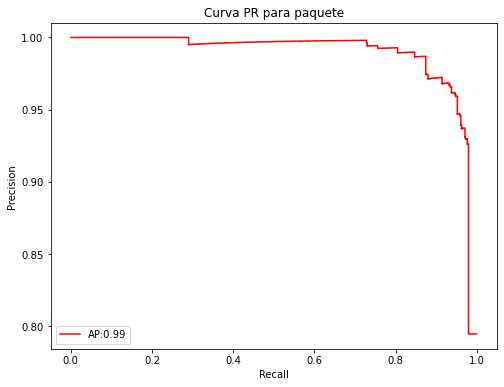

In [15]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from numpy import argmax
# Curva Precision-Recall para etiqueta
_, ax = plt.subplots(figsize=(8, 6))
prec, recall, thres = precision_recall_curve(y_true_list , y_score_list)
ap = average_precision_score(y_true_list , y_score_list)
label = 'AP:' + str(round(ap,2))
# Etiquetas gráfico
display = PrecisionRecallDisplay(precision=prec, recall=recall)
display.plot(ax=ax, label = label, color = 'red')
display.ax_.set_title('Curva PR para paquete')
display.ax_.legend(loc = 'lower left' )
#-------------------------------------------------------------------------------
## Calcular f1-score
#fscore = (2 * prec * recall) / (prec + recall)
## Enontrar índice en que se maximiza f1-score
#ix = argmax(fscore)
#print('Mejor umbral=%f, Precision = %.3f, Recall = %.3f, F-Score=%.3f'
# % (thres[ix], prec[ix], recall[ix], fscore[ix]))
## plot the roc curve for the model
################################
#fig = display.ax_.get_figure() 
#fig.set_figwidth(250)
#fig.set_figheight(250) 
################################
#display.ax_.scatter(recall[ix], prec[ix], marker='o', color='red', label='Best')
#plt.annotate(str(round(thres[ix],4))+ ' (' + str(round(recall[ix],4)) + ' , ' + str(round(prec[ix],4)) + ')',
#            xy=(recall[ix], prec[ix]), xycoords='data',
#            xytext=(recall[ix]-0.02, prec[ix]+0.03), textcoords='data',
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            )
#######################################################################
#for ix in range(len(thres)):
#  if ix%2==0:
#    plt.scatter(recall[ix], prec[ix], marker='*', color='black')
#    plt.annotate(str(round(thres[ix],2)),
#            xy=(recall[ix], prec[ix]), xycoords='data',
#            xytext=(recall[ix], prec[ix]), textcoords='data', horizontalalignment = 'center',
#            verticalalignment = 'bottom')
#    plt.annotate('(' + str(round(recall[ix],2)) + ' , ' + str(round(prec[ix],2)) + ')',
#            xy=(recall[ix], prec[ix]), xycoords='data',
#            xytext=(recall[ix], prec[ix]), textcoords='data', horizontalalignment = 'center',
#            verticalalignment = 'top')
#
plt.plot()
plt.savefig('/home/jupyter/Object Detection/graficos/pr2')
#plt.show()
###################################################################### 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
#y_test = np.array(y_test_list)
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
#cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
accuracy = (cf_matrix[0][0]+cf_matrix[1][1])/(cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0]+cf_matrix[1][1])
recall = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1])
precision = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0])
F1 = 2*recall*precision/(recall + precision)
print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
#y_test = np.array(y_test_list)
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
#cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
accuracy = (cf_matrix[0][0]+cf_matrix[1][1])/(cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0]+cf_matrix[1][1])
recall = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1])
precision = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0])
F1 = 2*recall*precision/(recall + precision)
print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()

Graficar bbox para 1 imagen mediante su enlace

In [3]:
# cargar modelo detector de objetos
device = 'cuda'
#device = 'cpu'
model_path = '/home/jupyter/Score/Modelos/model_cf_12y3_1.pth'
num_classes = 2
od_model = get_object_detection_model(num_classes)
od_model_dict = torch.load(model_path, map_location=torch.device(device))
od_model.load_state_dict(od_model_dict['model_state_dict'])

<All keys matched successfully>

(0, 1)
(0, 2)
(0, 3)
(1, 2)
(1, 3)
(2, 3)
0.1276859876844618


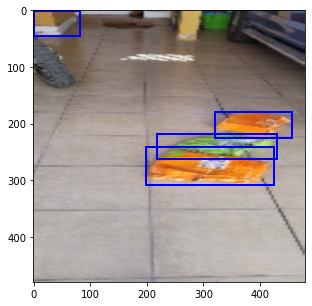

In [40]:
# Visualización de predicciones para 1 imagen mediante enlace 
import urllib
import itertools
from skimage import io, transform
url = 'https://prdadessacorptrl.blob.core.windows.net/cl-images/20220815172346-Falabella-149069257333-1-EVIDENCE.png'
url_open = urllib.request.urlopen(url)
image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
device = 'cuda'
od_model.to(device)
od_model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
    # DETECTOR DE OBJETOS
    # transformación para aplicar detector
    t_img_0 = transform.resize(image, (480, 480))
    # obtener area de la imagen
    area_img = t_img_0.shape[0]*t_img_0.shape[1]
    t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
    od_prediction = od_model([t_img])
    if od_prediction[0]['labels'].shape[0] > 0 and \
        max(od_prediction[0]['scores']).item() >= 0.5:
          paquete = 1
    else:
        paquete = 0 
    # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
    boxes = od_prediction[0]['boxes'].to(device)
    scores = od_prediction[0]['scores'].to(device)
    scores = torch.where(scores >= 0.5, 1, 0)
    scores = torch.unsqueeze(scores, dim=0)
    scores_t = torch.transpose(scores, 0, 1)
    mult = torch.mul(boxes, scores_t)
    b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
    l =list(range(b.size()[0]))
    # recorrer cajas y calcular inter-area para cada combinación
    indice = 0
    interArea = 0
    for i in itertools.combinations(l, r=2):
        print(i)
        # obtener coordenadas de la inter-area
        x0 = max(b[i[0]][0], b[i[1]][0])
        y0 = max(b[i[0]][1], b[i[1]][1])
        x1 = min(b[i[0]][2], b[i[1]][2])
        y1 = min(b[i[0]][3], b[i[1]][3])
        
        dif_x = x0-x1
        dif_y = y0-y1
        
        if dif_x < 0 and dif_y < 0:
            # calcular inter-area
            interArea += dif_x*dif_y
        
    # sumar areas de cada bbox
    area_total_bbox = 0
    for box in b:
        # calcular area de cada bbox
        area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
        # calcular area total de bbox
        area_total_bbox += area_bbox
    
    # calcular la union de las areas de cada bbox
    union = area_total_bbox - interArea
    
    # calcular contexto
    if torch.is_tensor(union):
        contexto = union.item()/area_img
      
    else:
        contexto = union/area_img
    
    print(contexto)
    #plot_img_bbox(t_img_0, od_prediction[0])
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(t_img_0)
    indice = 0
    for score in od_prediction[0]['scores']:
        if score >= 0.5:
            box = boxes[indice]
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = patches.Rectangle(
                (x, y),
                width, height,
                linewidth = 2,
                edgecolor = 'b',
                facecolor = 'none')
            # Draw the bounding box on top of the image
            a.add_patch(rect)  
        indice+=1
    #plt.show()
    #plot_img_bbox(image.permute(1,2,0).to('cpu'), od_prediction[0].to('cpu'))